#### Introduction :
In our model trained with lstm with raw inputs of 9 time series data with a window size of 128, we got 90% accuracy.
Now we want to improve the accuracy more than 93% by  using divide and conquer rule in cnn.We want to make it easier for the model to predict our classes.We divided our 6 distinct classes into 2 abstract classes 'Dynamic' and 'Static'.We first build a binary CNN classifier which predicts if the activity is a dynamic/static activity.We then build our multiclass classifiers one to predict static activity and other one to predict dynamic activities.We divide the classification into subproblems and attain more accuracy

In [1]:
# walking, walking-up, walking-down -- dynamic
# sitting standing lying -- static

In [247]:
#### importing libraries
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from datetime import datetime
from sklearn.metrics import confusion_matrix
sns.set_style('whitegrid')
plt.rcParams['font.family'] = 'Dejavu Sans'

In [2]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

# Utility function to print the confusion matrix
def confusion_matrix_(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

In [299]:
## https://www.kaggle.com/grfiv4/plot-a-confusion-matrix
import itertools
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):



    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(20, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

### Data

In [4]:
# Data directory
DATADIR = 'UCI_HAR_Dataset'

In [5]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [6]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).values
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [7]:

def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]
    return y

In [8]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    x_train, x_test  = load_signals('train'), load_signals('test')
    y_train, y_test= load_y('train'), load_y('test')

    return x_train, x_test, y_train, y_test

In [9]:
# Importing tensorflow
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

In [10]:
# Configuring a session
session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

In [167]:
# Import Keras
from keras import backend as K
import keras
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

In [12]:
# Importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout

In [13]:
# Initializing parameters
epochs = 30
batch_size = 16
n_hidden = 32

In [40]:
# Utility function to count the number of classes
def _count_classes(y):
    
    return len(set([category for category in y]))

In [41]:
# Loading the train and test data
x_train, x_test, y_train, y_test = load_data()

In [42]:
print(x_train.shape)
print(x_test.shape)

(7352, 128, 9)
(2947, 128, 9)


In [43]:
timesteps = len(x_train[0])
input_dim = len(x_train[0][0])
n_classes = _count_classes(y_train)

print(timesteps)
print(input_dim)
print(len(x_train))

128
9
7352


In [44]:
print(y_train.shape,y_test.shape)

(7352,) (2947,)


### Model that predicts static / dynamic - Binary classification

In [219]:
def load_y_binclassifier(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]
    
    y[y<=3] = 0
    y[y>3] = 1
    return y

In [225]:
y_train2,y_test2 =   load_y_binclassifier('train'),load_y_binclassifier('test')


In [226]:
#### convert to ohe
y_train2_ohe,y_test2_ohe =  np.eye(2)[y_train2],np.eye(2)[y_test2]

In [227]:
print('+'*20,'Train-shapes','+'*20)
print('Shape of xtrain:',x_train.shape)
print('Shape of ytrain:',y_train2_ohe.shape)
print('+'*20,'Test-shapes','+'*20)
print('Shape of xtest:',x_test.shape)
print('Shape of ytest:',y_test2_ohe.shape)

++++++++++++++++++++ Train-shapes ++++++++++++++++++++
Shape of xtrain: (7352, 128, 9)
Shape of ytrain: (7352, 2)
++++++++++++++++++++ Test-shapes ++++++++++++++++++++
Shape of xtest: (2947, 128, 9)
Shape of ytest: (2947, 2)


##### Binary Classifier - Architecture ,training, Saving Best weights and prediction

In [229]:
model_binary = Sequential()


model_binary.add(Conv1D(100, 3, strides=2,input_shape=(128, 9), activation='relu',kernel_initializer = 'he_normal'))
model_binary.add(MaxPooling1D(2))
model_binary.add(BatchNormalization())
model_binary.add(Dropout(0.2))

model_binary.add(Flatten())

model_binary.add(Dense(32, activation='relu'))
model_binary.add(BatchNormalization())
model_binary.add(Dropout(0.2))
model_binary.add(Dense(2, activation='sigmoid'))

model_binary.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer = Adam())

model_binary.summary()

#### fittign the model and fitting the model with best weights
path = 'best_weights_binary.h5'
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=path,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history_binary = model_binary.fit(x_train,y_train2_ohe, epochs=20, batch_size=10,
                            validation_data=(x_test, y_test2_ohe),verbose=1,callbacks=[checkpoint])

model_binary.load_weights(path)
#Evaluate the model_dyn 
score_binary = model_binary.evaluate(x_test, y_test2_ohe)

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_27 (Conv1D)           (None, 63, 100)           2800      
_________________________________________________________________
max_pooling1d_27 (MaxPooling (None, 31, 100)           0         
_________________________________________________________________
batch_normalization_32 (Batc (None, 31, 100)           400       
_________________________________________________________________
dropout_37 (Dropout)         (None, 31, 100)           0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 3100)              0         
_________________________________________________________________
dense_26 (Dense)             (None, 32)                99232     
_________________________________________________________________
batch_normalization_33 (Batc (None, 32)              

#### Plot Confusion matrix (Abstract labels):


In [231]:
y_pred_binary = model_binary.predict(x_test)

In [232]:
mat = confusion_matrix_(y_test2_ohe,y_pred_binary)

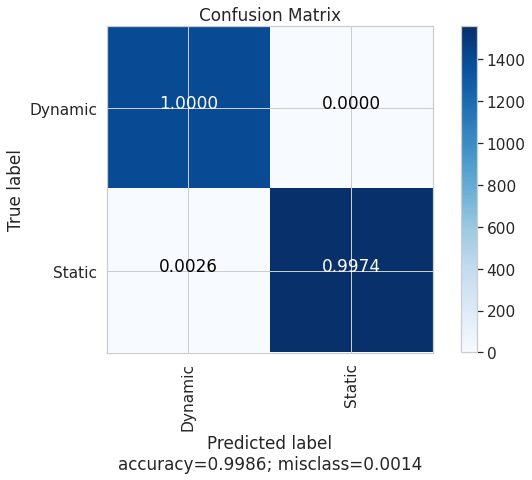

In [250]:
plot_confusion_matrix(mat.values,normalize    = True,
                      target_names = ["Dynamic",'Static'],
                      title        = "Confusion Matrix")

### Build dataset to train CNN for prediction of dynamic labels

In [237]:
import random 

In [238]:
# https://stackoverflow.com/questions/29831489/convert-array-of-indices-to-1-hot-encoded-numpy-array
n_classes = 3
### creating 
dynamic_idx_tr = np.where((y_train == 1)|(y_train == 2)|(y_train == 3))[0]
dynamic_idx_te = np.where((y_test == 1)|(y_test == 2)|(y_test == 3))[0]

# Shuffle dynamic data indexes
rand = random.random()
random.shuffle(dynamic_idx_tr, lambda: rand)
random.shuffle(dynamic_idx_te, lambda: rand)

## creating our trainset 
x_tr_dynamic = x_train[dynamic_idx_tr]
y_tr_dynamic = y_train[dynamic_idx_tr]

x_te_dynamic = x_test[dynamic_idx_te]
y_te_dynamic = y_test[dynamic_idx_te]

### label the y_actuals 0,1,2
y_tr_dynamic = np.array(y_tr_dynamic.map({1:0,2:1,3:2}))
y_te_dynamic = np.array(y_te_dynamic.map({1:0,2:1,3:2}))


### one hot encode y
y_tr_dy_ohe = np.eye(n_classes)[y_tr_dynamic]

y_te_dy_ohe = np.eye(n_classes)[y_te_dynamic]

print('Example train o/p',y_tr_dy_ohe[0])

Example train o/p [1. 0. 0.]


In [239]:
print('+'*20,'Train-shapes','+'*20)
print('Shape of xtrain:',x_tr_dynamic.shape)
print('Shape of ytrain:',y_tr_dy_ohe.shape)
print('+'*20,'Test-shapes','+'*20)
print('Shape of xtest:',x_te_dynamic.shape)
print('Shape of ytest:',y_te_dy_ohe.shape)

++++++++++++++++++++ Train-shapes ++++++++++++++++++++
Shape of xtrain: (3285, 128, 9)
Shape of ytrain: (3285, 3)
++++++++++++++++++++ Test-shapes ++++++++++++++++++++
Shape of xtest: (1387, 128, 9)
Shape of ytest: (1387, 3)


In [240]:
timesteps = len(x_tr_dynamic[0])
input_dim = len(x_tr_dynamic[0][0])
#n_classes = _count_classes(y_tr_dy_ohe)

print(timesteps)
print(input_dim)
print(len(x_tr_dynamic))

128
9
3285


##### LSTM Architecture - Dynamic Model


In [241]:
from keras.layers import LSTM, Dropout, TimeDistributed, Dense, Activation, Embedding,Flatten
from keras.layers import BatchNormalization
from keras.layers import Conv1D, MaxPooling1D
from keras.optimizers import Adam

dynamic = Sequential()


dynamic.add(Conv1D(50, 3,strides=2,input_shape=(128, 9),activation='relu',kernel_initializer = 'he_normal'))
dynamic.add(MaxPooling1D(2))

dynamic.add(Conv1D(80, 3,strides=2,activation='relu',kernel_initializer = 'he_normal'))
dynamic.add(MaxPooling1D(2))


dynamic.add(LSTM(64,activation = 'relu',kernel_initializer = 'he_normal',return_sequences = True))
dynamic.add(Dropout(0.25))
dynamic.add(BatchNormalization())

dynamic.add(LSTM(32,activation = 'relu',kernel_initializer = 'he_normal',return_sequences = True))
dynamic.add(Dropout(0.25))
dynamic.add(BatchNormalization())

dynamic.add(Flatten())


dynamic.add(Dense(3, activation='sigmoid'))


dynamic.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer = Adam())

dynamic.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_28 (Conv1D)           (None, 63, 50)            1400      
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 31, 50)            0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 15, 80)            12080     
_________________________________________________________________
max_pooling1d_29 (MaxPooling (None, 7, 80)             0         
_________________________________________________________________
lstm_23 (LSTM)               (None, 7, 64)             37120     
_________________________________________________________________
dropout_39 (Dropout)         (None, 7, 64)             0         
_________________________________________________________________
batch_normalization_34 (Batc (None, 7, 64)           

In [243]:
path = 'best_weights_dynamic.h5'
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=path,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history_dynamic = dynamic.fit(x_tr_dynamic,y_tr_dy_ohe, epochs=20, batch_size=10,
                              validation_data=(x_te_dynamic, y_te_dy_ohe),
                              callbacks=[checkpoint],verbose=1)

dynamic.load_weights(path)
#Evaluate the model_dyn 
score_dynamic = dynamic.evaluate(x_te_dynamic, y_te_dy_ohe)

Epoch 1/20
329/329 [==============================] - 3s 8ms/step - loss: 0.0037 - accuracy: 0.9988 - val_loss: 0.1338 - val_accuracy: 0.9654
Epoch 2/20
329/329 [==============================] - 3s 8ms/step - loss: 3.8839e-04 - accuracy: 1.0000 - val_loss: 0.1022 - val_accuracy: 0.9690
Epoch 3/20
329/329 [==============================] - 3s 8ms/step - loss: 2.5052e-04 - accuracy: 1.0000 - val_loss: 0.1134 - val_accuracy: 0.9676
Epoch 4/20
329/329 [==============================] - 3s 8ms/step - loss: 2.4136e-04 - accuracy: 1.0000 - val_loss: 0.1419 - val_accuracy: 0.9632
Epoch 5/20
329/329 [==============================] - 3s 9ms/step - loss: 9.8075e-05 - accuracy: 1.0000 - val_loss: 0.1520 - val_accuracy: 0.9640
Epoch 6/20
329/329 [==============================] - 3s 8ms/step - loss: 1.1522e-04 - accuracy: 1.0000 - val_loss: 0.2415 - val_accuracy: 0.9553
Epoch 7/20
329/329 [==============================] - 3s 8ms/step - loss: 7.7078e-05 - accuracy: 1.0000 - val_loss: 0.1806 - val

In [244]:
print('****'*20)
print('\n')

print(' \t Calculated test accuracy for dynamic model  :',score_dynamic[1],'\t')
print('\n')
print('****'*20)

********************************************************************************


 	 Calculated test accuracy for dynamic model  : 0.9689978361129761 	


********************************************************************************


####  Plot loss and accuracy for dynamic  :


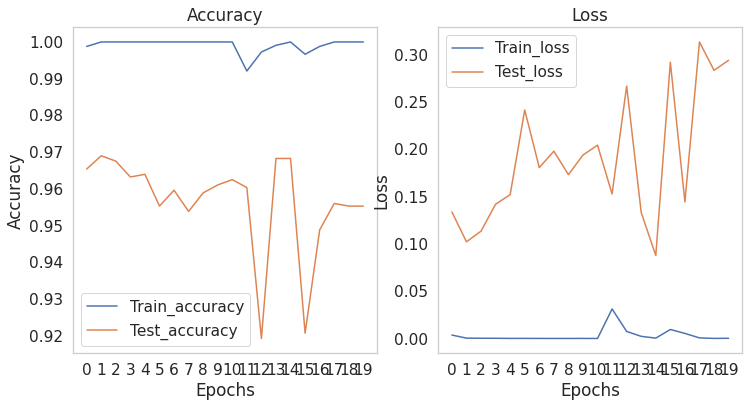

In [248]:
def plt_loss_accuracy(train_acc,test_acc,train_loss,test_loss):
    fig = plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    sns.lineplot(x=np.arange(20),y=train_acc,label='Train_accuracy')
    sns.lineplot(x=np.arange(20),y=test_acc,label='Test_accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xticks(ticks=np.arange(20))
    plt.title('Accuracy')
    plt.grid()
    
    plt.subplot(1,2,2)
    sns.lineplot(x=np.arange(20),y=train_loss,label='Train_loss')
    sns.lineplot(x=np.arange(20),y=test_loss,label='Test_loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(ticks=np.arange(20))
    plt.title('Loss')
    
    plt.grid()
    plt.show()
plt_loss_accuracy(history_dynamic.history['accuracy'],history_dynamic.history['val_accuracy'],
                 history_dynamic.history['loss'],history_dynamic.history['val_loss'])

#### Plot Confusion matrix - (Dynamic labels) :


In [55]:
y_pred_dynamic = dynamic.predict(x_te_dynamic)

In [63]:
mat = confusion_matrix_(y_te_dy_ohe,y_pred_dynamic)

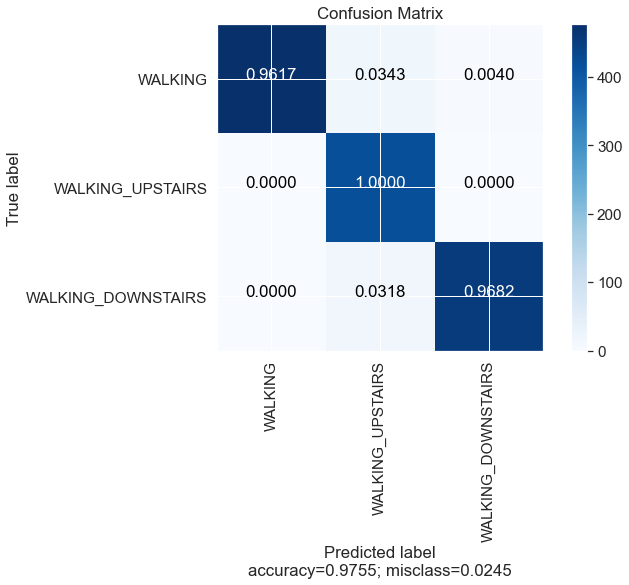

In [103]:
plot_confusion_matrix(mat.values,normalize    = True,
                      target_names = ["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS"],
                      title        = "Confusion Matrix")

### Build dataset to train CNN for static 

In [129]:
# https://stackoverflow.com/questions/29831489/convert-array-of-indices-to-1-hot-encoded-numpy-array
n_classes = 3
### creating 
static_idx_tr = np.where((y_train == 4)|(y_train == 5)|(y_train == 6))[0]
static_idx_te = np.where((y_test == 4)|(y_test == 5)|(y_test == 6))[0]

# Shuffle static data indexes
rand = random.random()
random.shuffle(static_idx_tr, lambda: rand)
random.shuffle(static_idx_te, lambda: rand)

## creating our trainset 
x_tr_static = x_train[static_idx_tr]
y_tr_static = y_train[static_idx_tr]

x_te_static = x_test[static_idx_te]
y_te_static = y_test[static_idx_te]

### label the y_actuals 0,1,2
y_tr_static = np.array(y_tr_static.map({4:0,5:1,6:2}))
y_te_static = np.array(y_te_static.map({4:0,5:1,6:2}))


### one hot encode y
y_tr_st_ohe = np.eye(n_classes)[y_tr_static]

y_te_st_ohe = np.eye(n_classes)[y_te_static]

print('Example train o/p',y_tr_st_ohe[0])

Example train o/p [0. 1. 0.]


In [130]:
print('+'*20,'Train-shapes','+'*20)
print('Shape of xtrain:',x_tr_static.shape)
print('Shape of ytrain:',y_tr_st_ohe.shape)
print('+'*20,'Test-shapes','+'*20)
print('Shape of xtest:',x_te_static.shape)
print('Shape of ytest:',y_te_st_ohe.shape)

++++++++++++++++++++ Train-shapes ++++++++++++++++++++
Shape of xtrain: (4067, 128, 9)
Shape of ytrain: (4067, 3)
++++++++++++++++++++ Test-shapes ++++++++++++++++++++
Shape of xtest: (1560, 128, 9)
Shape of ytest: (1560, 3)


In [131]:
timesteps = len(x_tr_static[0])
input_dim = len(x_tr_static[0][0])
#n_classes = _count_classes(y_tr_dy_ohe)

print(timesteps)
print(input_dim)
print(len(x_tr_static))

128
9
4067


##### LSTM Architecture - Static Model


In [168]:
model_static = Sequential()


model_static.add(Conv1D(100, 3, input_shape=(128, 9), activation='tanh',kernel_initializer = 'he_normal'))
model_static.add(MaxPooling1D(2))
model_static.add(BatchNormalization())
model_static.add(Dropout(0.2))


model_static.add(LSTM(80,activation = 'tanh',kernel_initializer = 'he_normal',return_sequences = True))
model_static.add(Dropout(0.5))



model_static.add(Flatten())


model_static.add(Dense(3, activation='sigmoid'))



model_static.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer = 'adam')

model_static.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_25 (Conv1D)           (None, 126, 100)          2800      
_________________________________________________________________
max_pooling1d_25 (MaxPooling (None, 63, 100)           0         
_________________________________________________________________
batch_normalization_29 (Batc (None, 63, 100)           400       
_________________________________________________________________
dropout_33 (Dropout)         (None, 63, 100)           0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 63, 80)            57920     
_________________________________________________________________
dropout_34 (Dropout)         (None, 63, 80)            0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 5040)            

In [172]:
path = 'best_weights_static.h5'
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=path,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history_static = model_static.fit(x_tr_static,y_tr_st_ohe, epochs=20, batch_size=10,
                            validation_data=(x_te_static, y_te_st_ohe),verbose=1,callbacks=[checkpoint])

model_static.load_weights(path)
#Evaluate the model
score_static = model_static.evaluate(x_te_static, y_te_st_ohe)

Epoch 1/20
407/407 [==============================] - 14s 34ms/step - loss: 0.1760 - accuracy: 0.9314 - val_loss: 0.1816 - val_accuracy: 0.9346
Epoch 2/20
407/407 [==============================] - 16s 39ms/step - loss: 0.1614 - accuracy: 0.9366 - val_loss: 0.2071 - val_accuracy: 0.9353
Epoch 3/20
407/407 [==============================] - 16s 38ms/step - loss: 0.1618 - accuracy: 0.9314 - val_loss: 0.2081 - val_accuracy: 0.9109
Epoch 4/20
407/407 [==============================] - 15s 38ms/step - loss: 0.1622 - accuracy: 0.9363 - val_loss: 0.1979 - val_accuracy: 0.9244
Epoch 5/20
407/407 [==============================] - 16s 39ms/step - loss: 0.1471 - accuracy: 0.9393 - val_loss: 0.1711 - val_accuracy: 0.9423
Epoch 6/20
407/407 [==============================] - 16s 38ms/step - loss: 0.1398 - accuracy: 0.9476 - val_loss: 0.1840 - val_accuracy: 0.9442
Epoch 7/20
407/407 [==============================] - 16s 38ms/step - loss: 0.1384 - accuracy: 0.9403 - val_loss: 0.1605 - val_accuracy:

In [173]:
print('****'*20)
print('\n')

print(' \t Calculated test accuracy for dynamic model  :',score_static[1],'\t')
print('\n')
print('****'*20)

********************************************************************************


 	 Calculated test accuracy for dynamic model  : 0.9487179517745972 	


********************************************************************************


####  Plot loss and accuracy for static  :


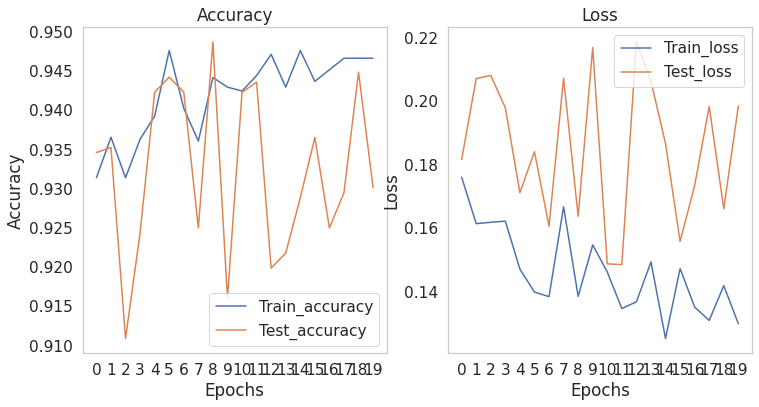

In [249]:
 
plt_loss_accuracy(history_static.history['accuracy'],history_static.history['val_accuracy'],
                 history_static.history['loss'],history_static.history['val_loss'])

#### Plot Confusion matrix (static labels) :


In [184]:
y_pred_static = model_static.predict(x_te_static)

In [185]:
mat = confusion_matrix_(y_te_st_ohe,y_pred_static)

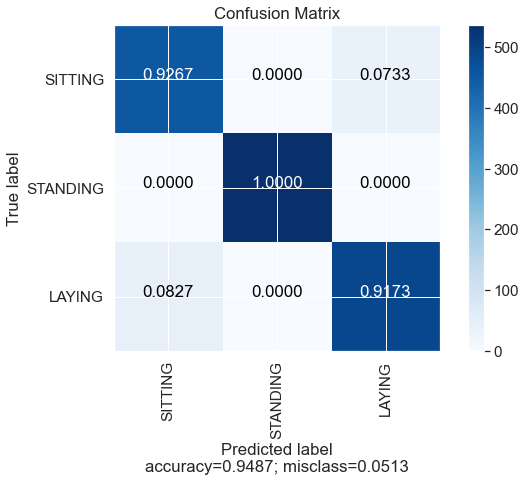

In [186]:
plot_confusion_matrix(mat.values,normalize    = True,
                      target_names = ["SITTING", "STANDING", "LAYING"],
                      title        = "Confusion Matrix")

##### Generating  final predictions :: by Divide and Conquer


In [279]:
def predict_all(x_test):  
    ### predict if it belongs to dynamic class or static class 
    ## later perform multiclass classification on predicting dynamic and static labels
    stat_dynamic_predictions = []
    static_pointer,dynamic_pointer=0,0
    for inp in x_test:
        inp = inp.reshape(1,128,9)
        abs_class_pred  = model_binary.predict(inp)
        abs_class_pred  = np.argmax(abs_class_pred, axis=1) + 1

        if abs_class_pred == 1 : ### dynamic
            dynamic_pred =  dynamic.predict(inp)
            dynamic_pred =   np.argmax(dynamic_pred, axis=1) + 1 
            stat_dynamic_predictions.append(dynamic_pred[0])
        elif abs_class_pred ==2 :  ### static
            static_pred =  model_static.predict(inp)
            static_pred =   np.argmax(static_pred, axis=1) + 4
            stat_dynamic_predictions.append(static_pred[0])
    return stat_dynamic_predictions

In [280]:
predict_all = predict_all(x_test)

In [294]:
cm = metrics.confusion_matrix(y_test,predict_all)

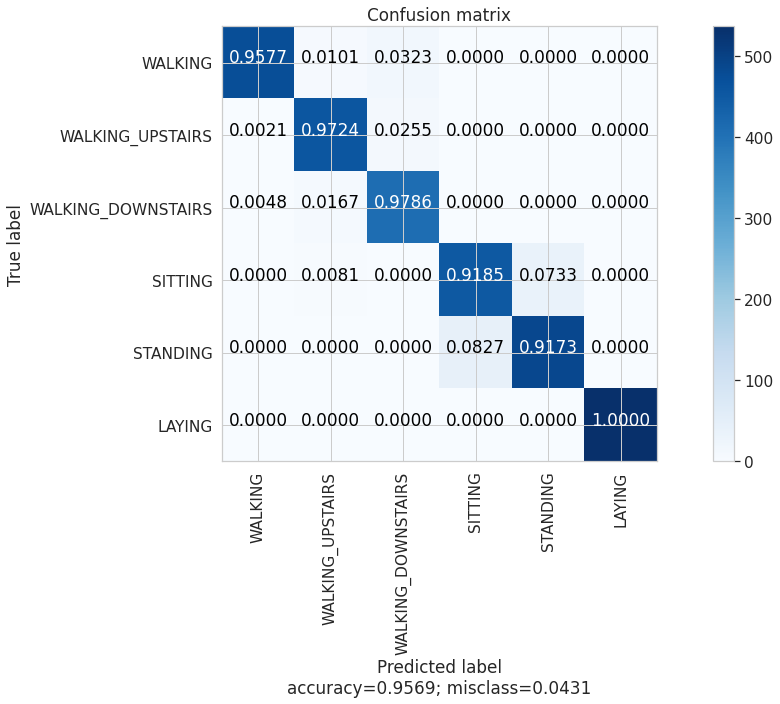

In [300]:
plot_confusion_matrix(cm,target_names=['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS','SITTING','STANDING',
                                     'LAYING'],title='Confusion matrix',cmap=None,normalize=True)

##### Observations :
* We can see that with divide and conquer method we improved our model performance from 90% to 95.6% accuracy on testset.

In [ ]:
##### referencess 

### https://github.com/heeryoncho/sensors2018cnnhar/tree/master/data/UCI%20HAR%20Dataset
## https://www.researchgate.net/figure/Overview-of-our-divide-and-conquer-based-1D-CNN-HAR-with-test-data-sharpening-Our_fig1_324224939
##https://www.researchgate.net/publication/324224939_Divide_and_Conquer-Based_1D_CNN_Human_Activity_Recognition_Using_Test_Data_Sharpening